In [1]:
# https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN/tree/master
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# https://github.com/pytorch/tutorials/blob/main/intermediate_source/reinforcement_q_learning.py

In [2]:
import argparse
import gym
from collections import deque
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from sklearn.linear_model import LinearRegression
import numpy as np

from agent import Agent
from processing import process_state_image, generate_state_frame_stack_from_queue


### Variables

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
seed = 77
episodes = 500
frame_stack_num = 4
memory_size = 10000
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.0005
batch_size = 64
update_every_n = 2

In [5]:
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
agent = Agent(
    action_space = env.action_space, 
    frame_stack_num = frame_stack_num,
    memory_size = memory_size,
    gamma = gamma,
    epsilon = epsilon,
    epsilon_min = epsilon_min,
    epsilon_decay = epsilon_decay,
    learning_rate = learning_rate,
    seed = seed)

In [6]:
summary(agent.model,(frame_stack_num, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             222
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 12, 13, 13]           1,164
         MaxPool2d-4             [-1, 12, 6, 6]               0
            Linear-5                  [-1, 216]          93,528
            Linear-6                    [-1, 5]           1,085
Total params: 95,999
Trainable params: 95,999
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.08
Params size (MB): 0.37
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


In [7]:
progress_bar = tqdm(total=episodes, desc="Episodes")

best_reward = float('-inf')
episode_list = []
losses = []
rewards = []

for e in range(episodes):
    state, info = env.reset(seed=seed)
    init_state = process_state_image(state)

    total_reward = 0
    negative_reward_counter = 0
    state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
    time_frame_counter = 1
    
    while True:
        current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)

        reward = 0
        for _ in range(frame_stack_num-1):
            next_state, r, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                done = True
            else: 
                done = False
            reward += r
            if done:
                break
        
        # Counts the number of negative rewards in a row
        negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

        # Extra bonus for the model if it uses full gas
        # actions = do nothing, steer left, steer right, gas, brake
        if action == 3:
            reward *= 1.5
        
        total_reward += reward
        if total_reward > best_reward:
            best_reward = total_reward

        next_state = process_state_image(next_state)
        state_frame_stack_queue.append(next_state)
        next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

        agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

        if done or negative_reward_counter >= 25 or total_reward < 0:
            break
        if len(agent.memory) > batch_size:
            l = agent.train(batch_size)
            
            episode_list.append(e)
            losses.append(l.item())
            rewards.append(total_reward)

        time_frame_counter += 1 
    
        progress_bar.set_postfix({"Total reward": total_reward, "Best reward": best_reward})
    progress_bar.update(1)

    if e % update_every_n == 0:
            agent.update_target_model()

# Saving the trained model
agent.save('trained_model.pth')

progress_bar.close()
env.close()

loss_df = pd.DataFrame({'episode': episode_list, 'loss': losses})
reward_df = pd.DataFrame({'episode': episode_list, 'reward': rewards})
loss_df.to_csv('loss.csv', index=False)
reward_df.to_csv('reward.csv', index=False)

Episodes: 100%|██████████| 500/500 [5:39:33<00:00, 40.75s/it, Total reward=1.19e+3, Best reward=1.24e+3]  


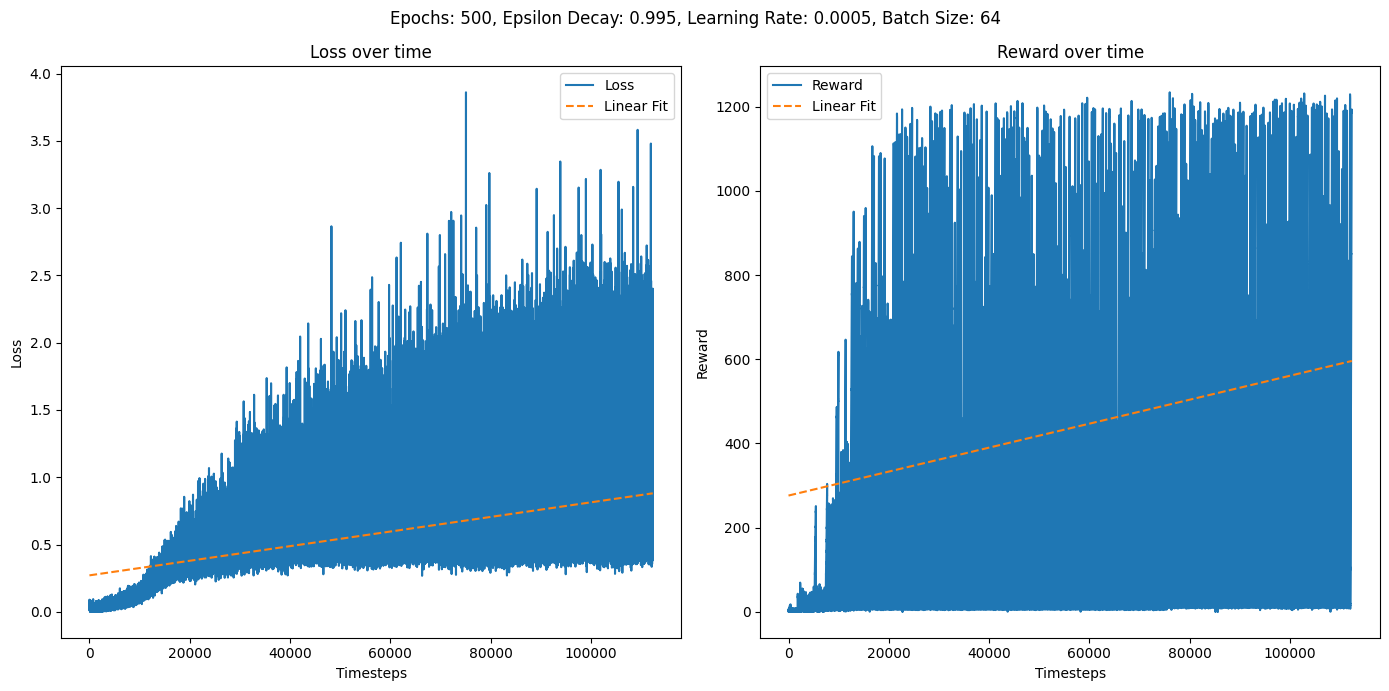

In [8]:
# Read data from CSV files
loss_df = pd.read_csv('loss.csv')
reward_df = pd.read_csv('reward.csv')

# Prepare data for linear regression
timesteps_loss = np.arange(len(loss_df['episode'])).reshape(-1, 1)
loss_values = loss_df['loss'].values

timesteps_reward = np.arange(len(reward_df['episode'])).reshape(-1, 1)
reward_values = reward_df['reward'].values

# Linear regression for loss
loss_model = LinearRegression()
loss_model.fit(timesteps_loss, loss_values)
loss_pred = loss_model.predict(timesteps_loss)

# Linear regression for reward
reward_model = LinearRegression()
reward_model.fit(timesteps_reward, reward_values)
reward_pred = reward_model.predict(timesteps_reward)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'Epochs: {episodes}, Epsilon Decay: {epsilon_decay}, Learning Rate: {learning_rate}, Batch Size: {batch_size}')

# Plot 1: Loss over time
axs[0].plot(range(len(loss_df['episode'])), loss_df['loss'], label='Loss')
axs[0].plot(range(len(loss_df['episode'])), loss_pred, label='Linear Fit', linestyle='--')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over time')
axs[0].legend()

# Plot 2: Reward over time
axs[1].plot(range(len(reward_df['episode'])), reward_df['reward'], label='Reward')
axs[1].plot(range(len(reward_df['episode'])), reward_pred, label='Linear Fit', linestyle='--')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Reward')
axs[1].set_title('Reward over time')
axs[1].legend()

plt.savefig('loss_reward.png')
plt.tight_layout()
plt.show()



In [9]:
def testing(env, agent, seed=77):
    state, info = env.reset(seed=seed)
    env = gym.wrappers.RecordVideo(env=env, video_folder="../Videos")

    init_state = process_state_image(state)

    state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
    total_reward = 0

    while True:
        current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)

        reward = 0
        for _ in range(frame_stack_num-1):
            next_state, r, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                done = True
            else:
                done = False
            reward += r
            if done:
                break

        total_reward += reward

        next_state = process_state_image(next_state)
        state_frame_stack_queue.append(next_state)

        if done:
            break

    print(f"Total reward after playing the game once: {total_reward}")
    env.close()
    return total_reward

In [10]:
# Load the model for testing
agent.load('trained_model.pth')
env = gym.make('CarRacing-v2', render_mode='human', continuous=False)
testing(env, agent)

c:\Users\fabia\anaconda3\envs\car\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\fabia\Desktop\Studium\RL\RL_CarRacing\Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\fabia\Desktop\Studium\RL\RL_CarRacing\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\fabia\Desktop\Studium\RL\RL_CarRacing\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\fabia\Desktop\Studium\RL\RL_CarRacing\Videos\rl-video-episode-0.mp4
Total reward after playing the game once: 903.7999999999845


903.7999999999845